### Data Dictionary


    Year: the observation year.
    Month: the observation month.
    Temp: the difference in degrees Celsius between the average global temperature in that period and a reference value. This data comes from the Climatic Research Unit at the University of East Anglia.
    
    CO2, N2O, CH4, CFC.11, CFC.12: atmospheric concentrations of carbon dioxide (CO2), nitrous oxide (N2O), methane  (CH4), trichlorofluoromethane (CCl3F; commonly referred to as CFC-11) and dichlorodifluoromethane (CCl2F2; commonly referred to as CFC-12), respectively. This data comes from the ESRL/NOAA Global Monitoring Division.

    CO2, N2O and CH4 are expressed in ppmv (parts per million by volume  -- i.e., 397 ppmv of CO2 means that CO2 constitutes 397 millionths of the total volume of the atmosphere)
    
    CFC.11 and CFC.12 are expressed in ppbv (parts per billion by volume). 

    Aerosols: the mean stratospheric aerosol optical depth at 550 nm. This variable is linked to volcanoes, as volcanic eruptions result in new particles being added to the atmosphere, which affect how much of the sun's energy is reflected back into space. This data is from the Godard Institute for Space Studies at NASA.
    
    TSI: the total solar irradiance (TSI) in W/m2 (the rate at which the sun's energy is deposited per unit area). Due to sunspots and other solar phenomena, the amount of energy that is given off by the sun varies substantially with time. This data is from the SOLARIS-HEPPA project website.
    
    MEI: multivariate El Nino Southern Oscillation index (MEI), a measure of the strength of the El Nino/La Nina-Southern Oscillation (a weather effect in the Pacific Ocean that affects global temperatures). This data comes from the ESRL/NOAA Physical Sciences Division.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("climate_change.csv",low_memory=False)

In [3]:
df

,Year,Month,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols,Temp
0,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149
...,...,...,...,...,...,...,...,...,...,...,...
303,2008,8,-0.266,384.15,1779.88,321.405,244.200,535.072,1365.6570,0.0036,0.407
304,2008,9,-0.643,383.09,1795.08,321.529,244.083,535.048,1365.6647,0.0043,0.378
305,2008,10,-0.780,382.99,1814.18,321.796,244.080,534.927,1365.6759,0.0046,0.440
306,2008,11,-0.621,384.13,1812.37,322.013,244.225,534.906,1365.7065,0.0048,0.394


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      308 non-null    int64  
 1   Month     308 non-null    int64  
 2   MEI       308 non-null    float64
 3   CO2       308 non-null    float64
 4   CH4       308 non-null    float64
 5   N2O       308 non-null    float64
 6   CFC11     308 non-null    float64
 7   CFC12     308 non-null    float64
 8   TSI       308 non-null    float64
 9   Aerosols  308 non-null    float64
 10  Temp      308 non-null    float64
dtypes: float64(9), int64(2)
memory usage: 26.6 KB


In [5]:
df.describe()

,Year,Month,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols,Temp
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,1995.662338,6.551948,0.275555,363.226753,1749.824513,312.391834,251.973068,497.524782,1366.070759,0.016657,0.256776
std,7.423197,3.447214,0.937918,12.647125,46.051678,5.225131,20.231783,57.826899,0.399610,0.029050,0.179090
min,1983.000000,1.000000,-1.635000,340.170000,1629.890000,303.677000,191.324000,350.113000,1365.426100,0.001600,-0.282000
25%,1989.000000,4.000000,-0.398750,353.020000,1722.182500,308.111500,246.295500,472.410750,1365.717050,0.002800,0.121750
50%,1996.000000,7.000000,0.237500,361.735000,1764.040000,311.507000,258.344000,528.356000,1365.980900,0.005750,0.248000
75%,2002.000000,10.000000,0.830500,373.455000,1786.885000,316.979000,267.031000,540.524250,1366.363250,0.012600,0.407250
max,2008.000000,12.000000,3.001000,388.500000,1814.180000,322.182000,271.494000,543.813000,1367.316200,0.149400,0.739000


In [6]:
df.shape

(308, 11)

### Data Visualization

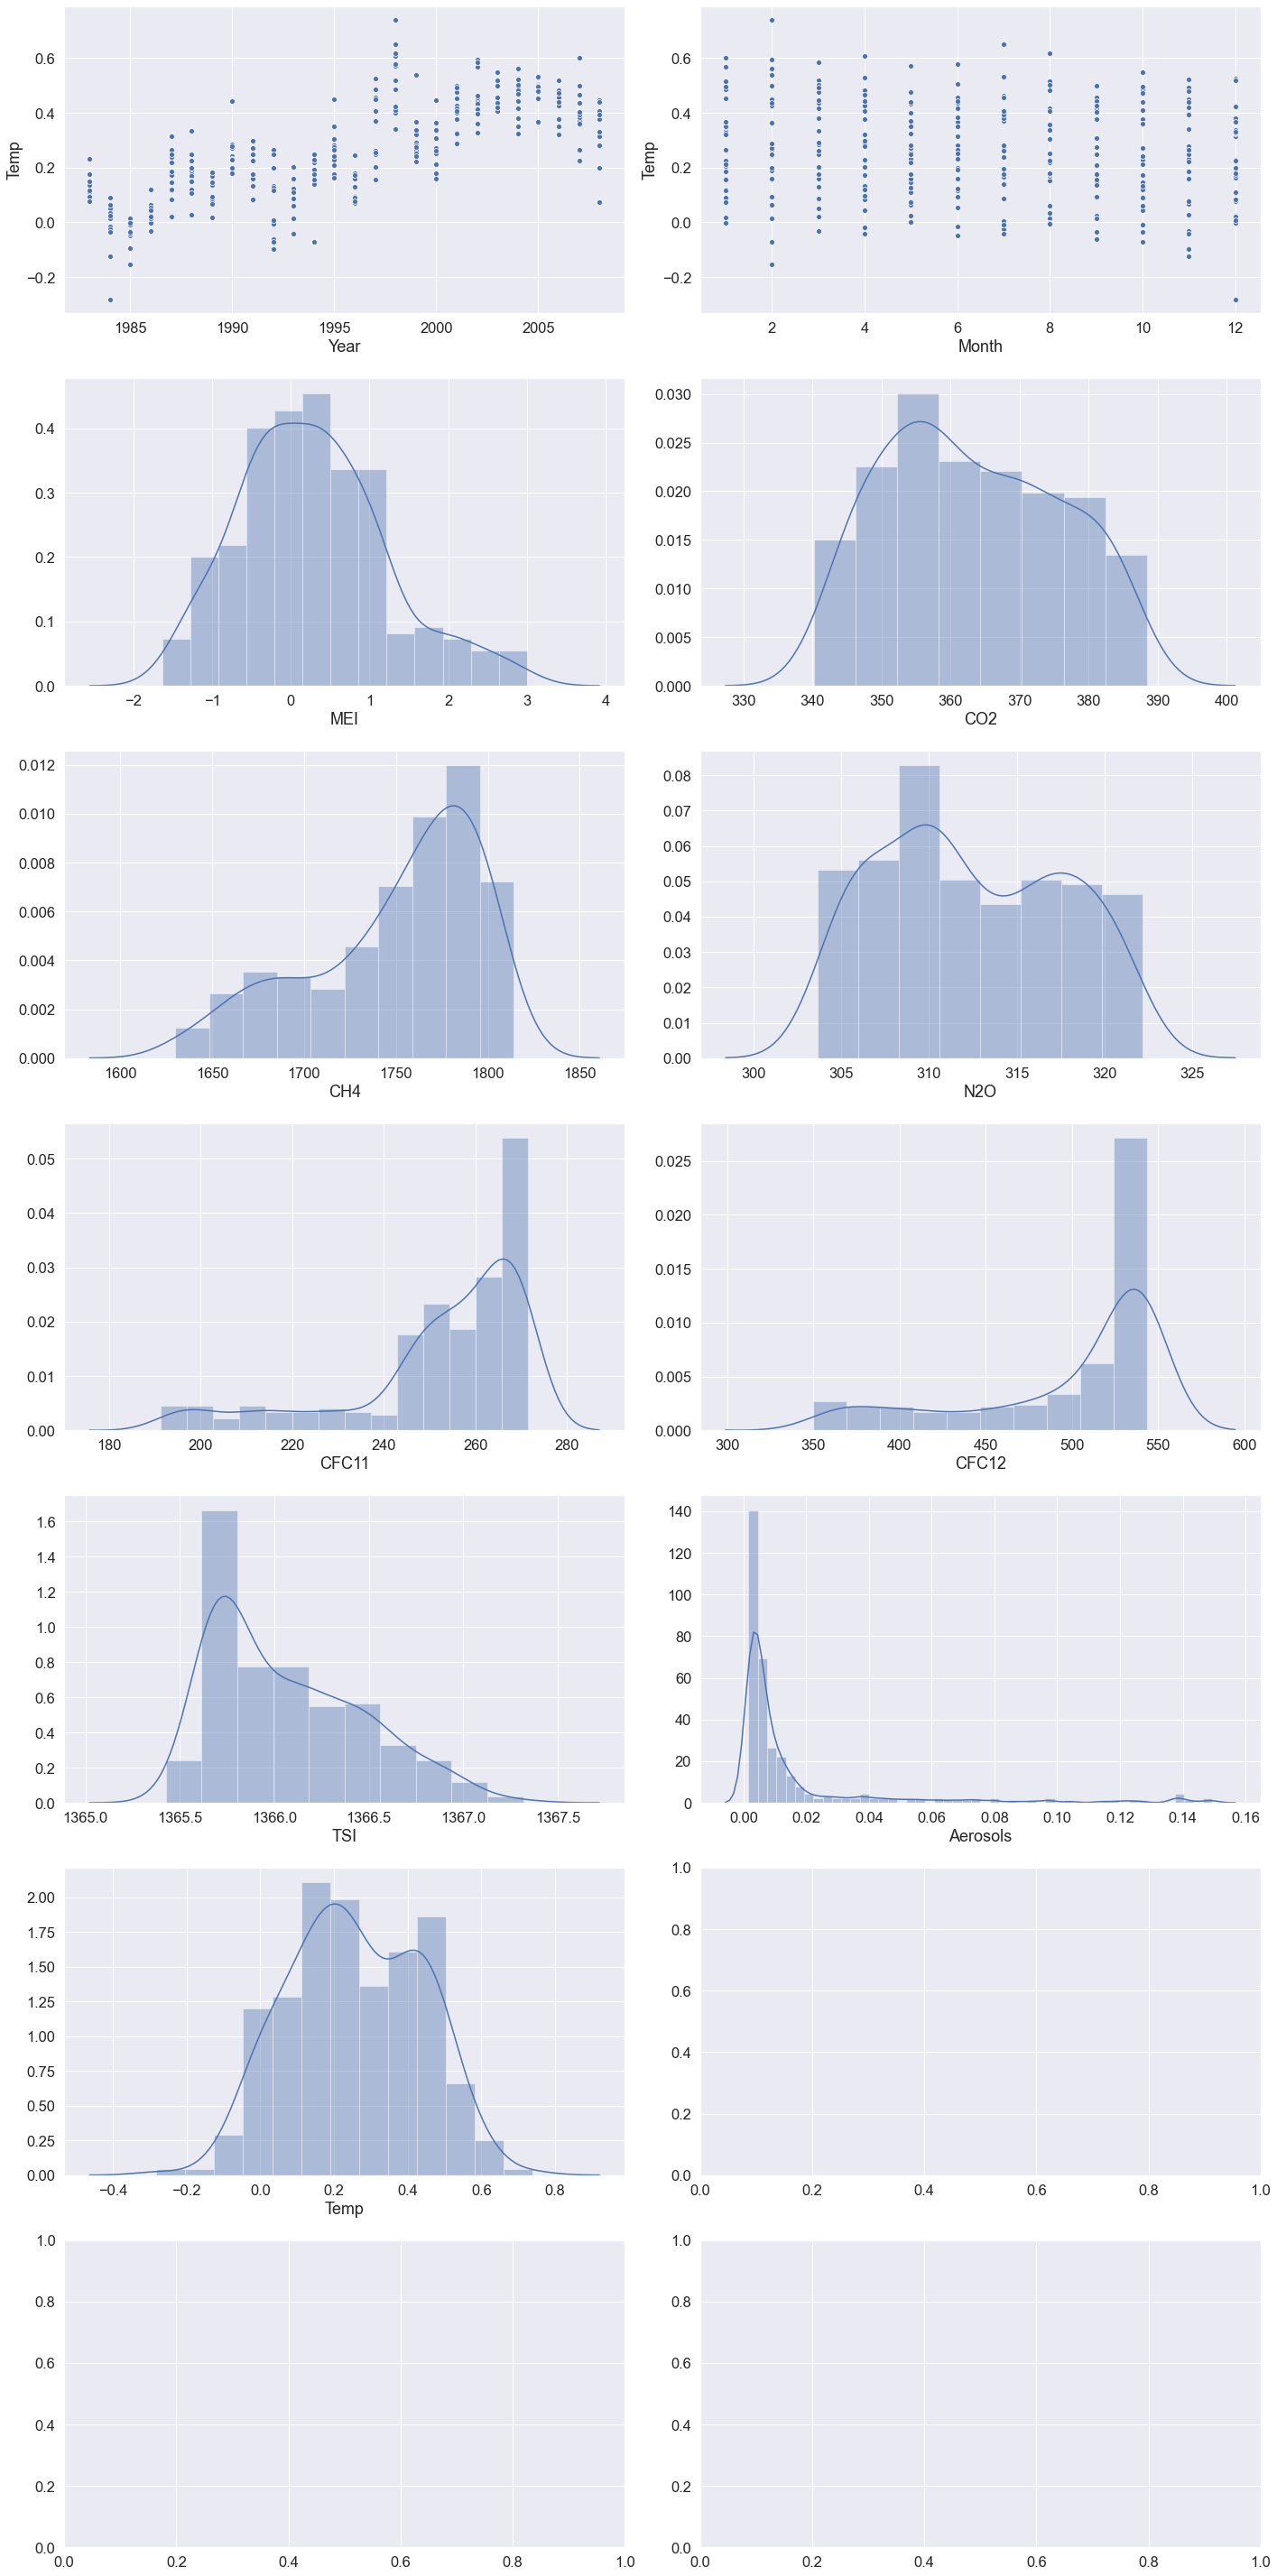

In [7]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.scatterplot(x=df.Year,y=df.Temp,data=df)
plt.subplot(7,2,2)
sns.scatterplot(x=df.Month,y=df.Temp,data=df)
plt.subplot(7,2,3)
sns.distplot(df.MEI)
plt.subplot(7,2,4)
sns.distplot(df.CO2)
plt.subplot(7,2,5)
sns.distplot(df.CH4)
plt.subplot(7,2,6)
sns.distplot(df.N2O)
plt.subplot(7,2,7)
sns.distplot(df.CFC11)
plt.subplot(7,2,8)
sns.distplot(df.CFC12)
plt.subplot(7,2,9)
sns.distplot(df.TSI)
plt.subplot(7,2,10)
sns.distplot(df.Aerosols)
plt.subplot(7,2,11)
sns.distplot(df.Temp)
plt.subplot(7,2,12)
#sns.countplot()
plt.subplot(7,2,13)
#sns.countplot()
plt.subplot(7,2,14)
#sns.scatterplot(x=df.Year,y=df.Temp,data=df)

plt.tight_layout()
plt.show()

In [8]:
df.corr()

,Year,Month,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols,Temp
Year,1.000000,-0.025789,-0.145345,0.985379,0.910563,0.994850,0.460965,0.870067,0.022353,-0.361884,0.755731
Month,-0.025789,1.000000,-0.016345,-0.096287,0.017558,0.012395,-0.014914,-0.001084,-0.032754,0.014845,-0.098016
MEI,-0.145345,-0.016345,1.000000,-0.152911,-0.105555,-0.162375,0.088171,-0.039836,-0.076826,0.352351,0.135292
CO2,0.985379,-0.096287,-0.152911,1.000000,0.872253,0.981135,0.401284,0.823210,0.017867,-0.369265,0.748505
CH4,0.910563,0.017558,-0.105555,0.872253,1.000000,0.894409,0.713504,0.958237,0.146335,-0.290381,0.699697
N2O,0.994850,0.012395,-0.162375,0.981135,0.894409,1.000000,0.412155,0.839295,0.039892,-0.353499,0.743242
CFC11,0.460965,-0.014914,0.088171,0.401284,0.713504,0.412155,1.000000,0.831381,0.284629,-0.032302,0.380111
CFC12,0.870067,-0.001084,-0.039836,0.823210,0.958237,0.839295,0.831381,1.000000,0.189270,-0.243785,0.688944
TSI,0.022353,-0.032754,-0.076826,0.017867,0.146335,0.039892,0.284629,0.189270,1.000000,0.083238,0.182186
Aerosols,-0.361884,0.014845,0.352351,-0.369265,-0.290381,-0.353499,-0.032302,-0.243785,0.083238,1.000000,-0.392069


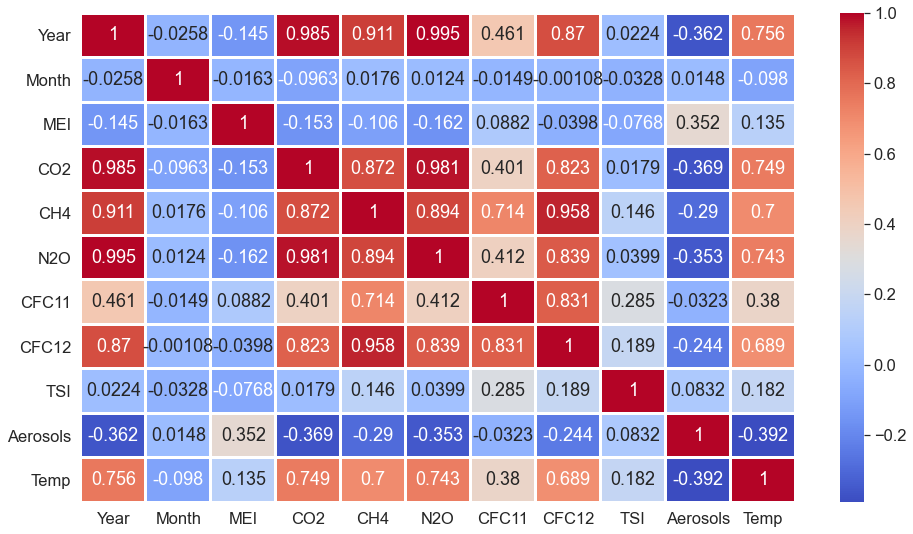

In [9]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.3g',linewidths=2)
plt.show()

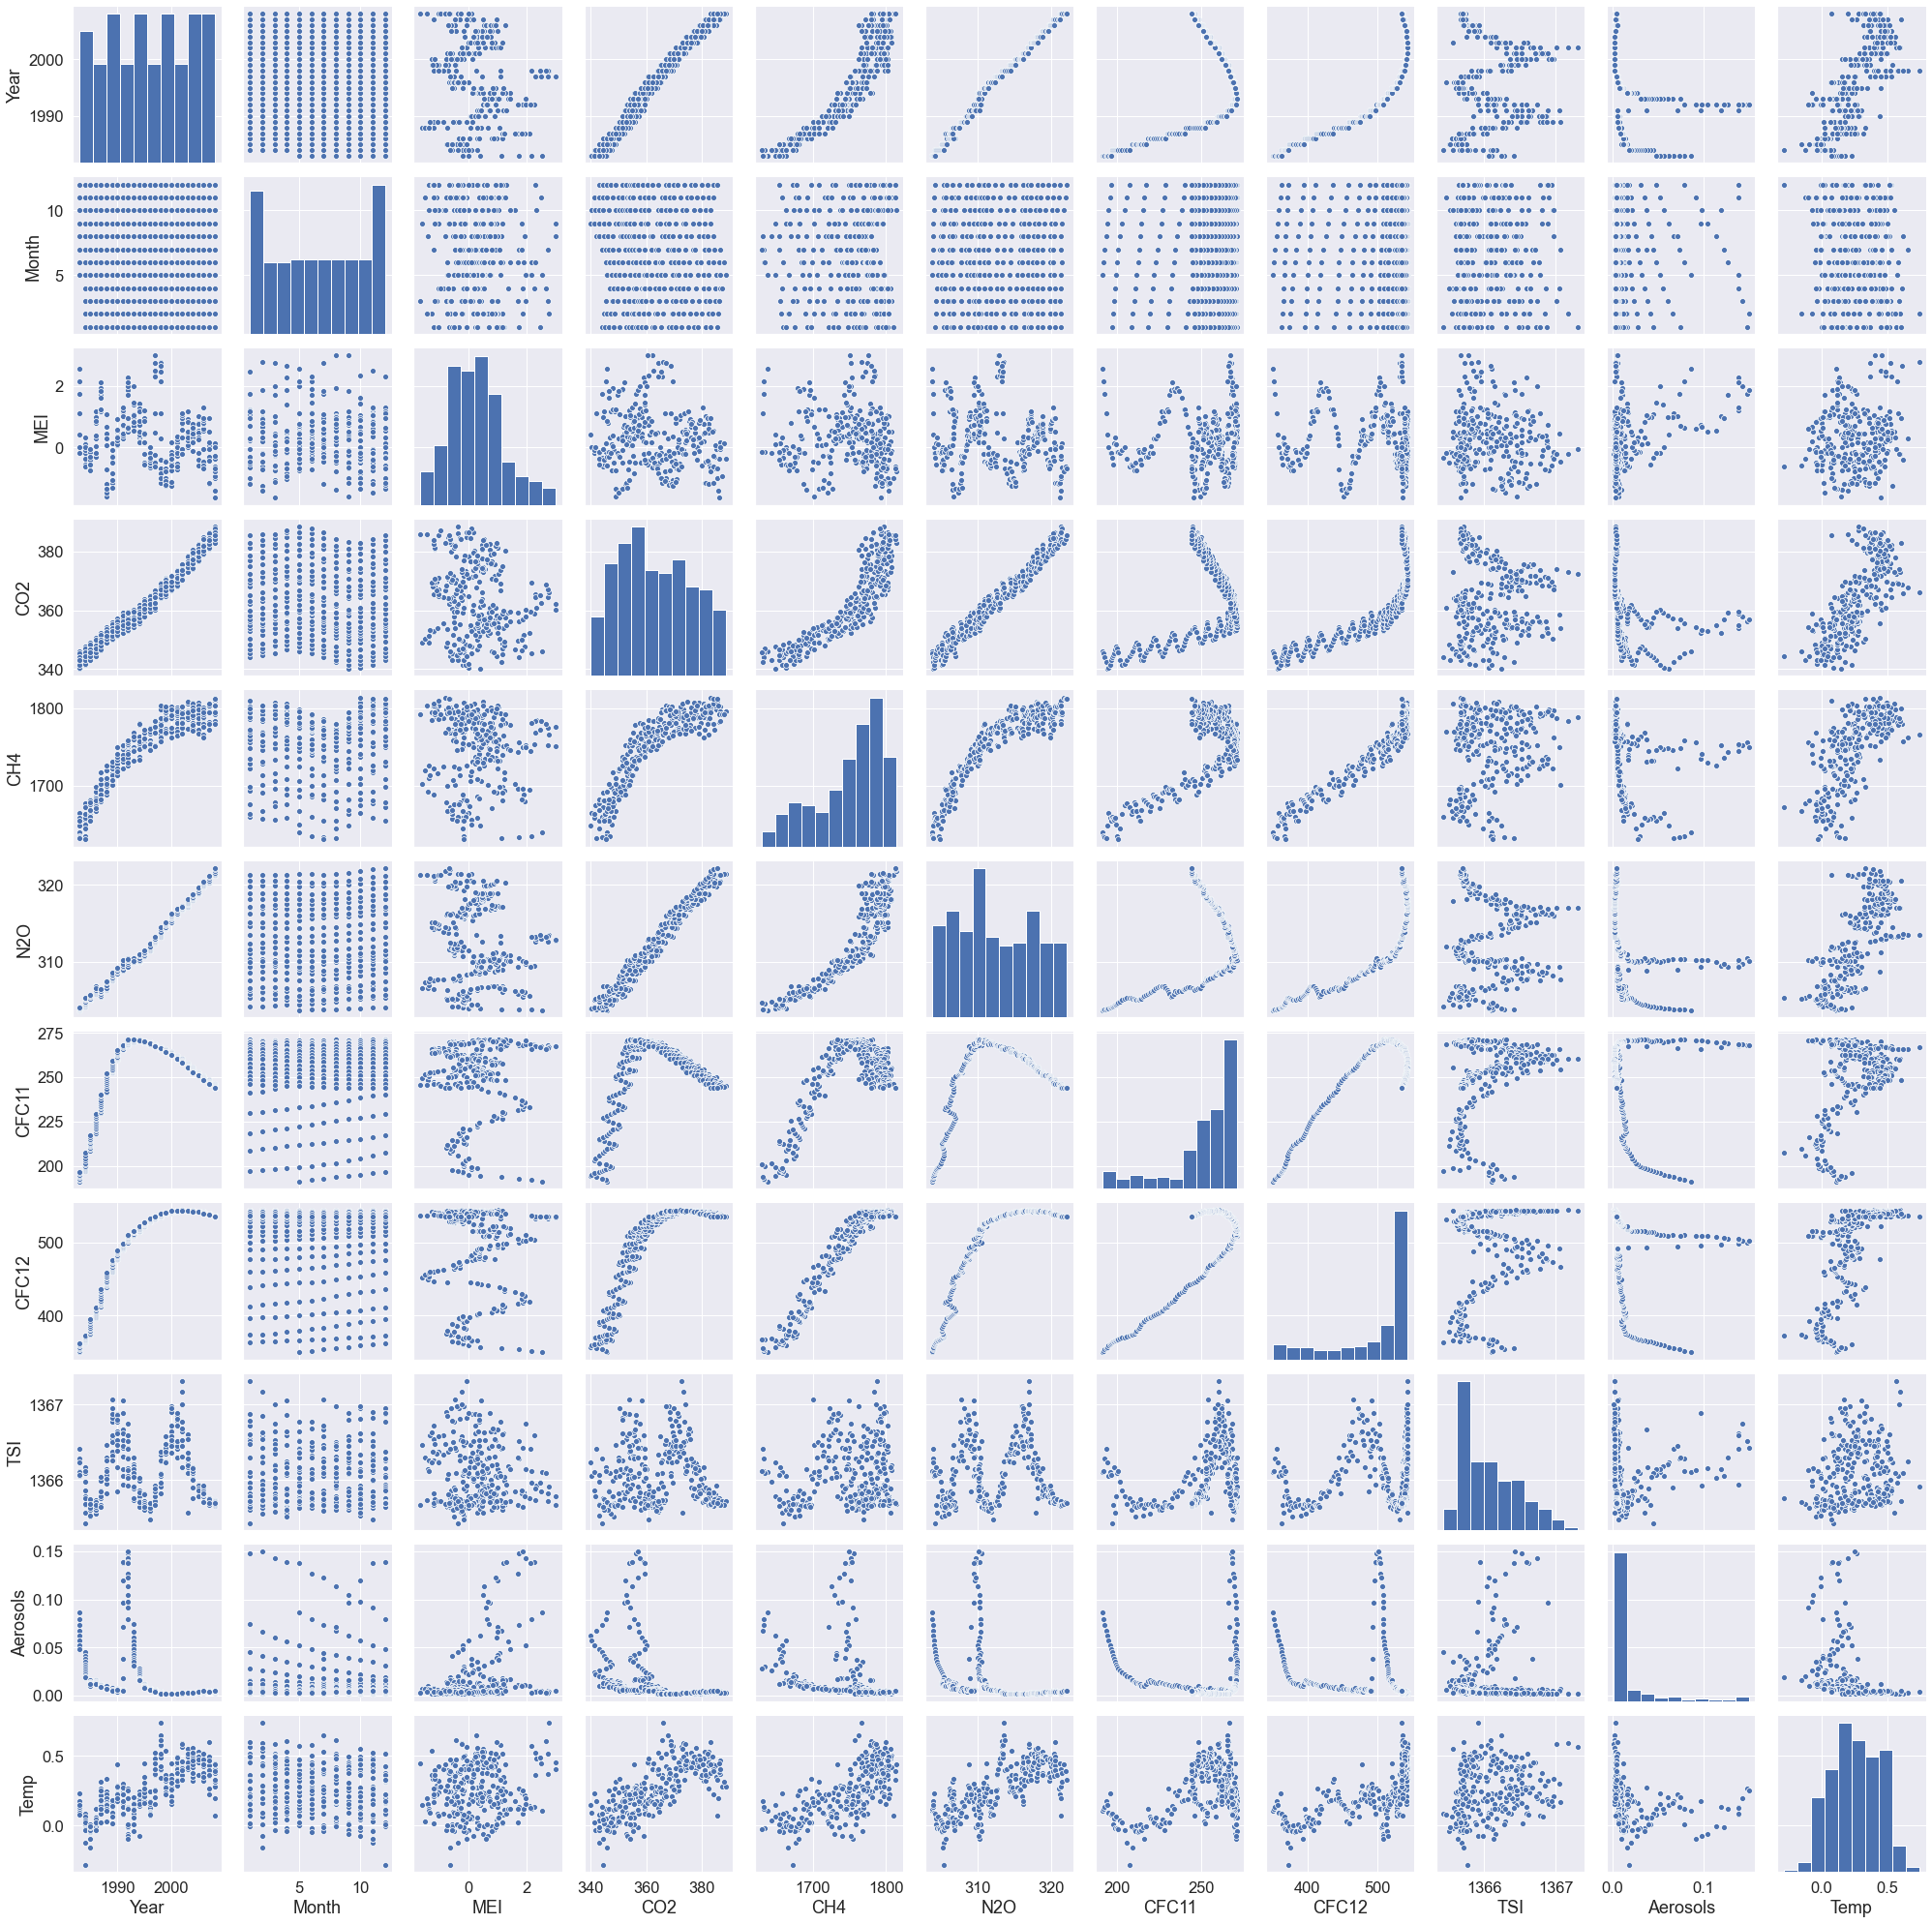

In [10]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [11]:
df.isnull().sum()

Year        0
Month       0
MEI         0
CO2         0
CH4         0
N2O         0
CFC11       0
CFC12       0
TSI         0
Aerosols    0
Temp        0
dtype: int64

### Treat Duplicate Values

In [12]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [13]:
df.describe()

,Year,Month,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols,Temp
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,1995.662338,6.551948,0.275555,363.226753,1749.824513,312.391834,251.973068,497.524782,1366.070759,0.016657,0.256776
std,7.423197,3.447214,0.937918,12.647125,46.051678,5.225131,20.231783,57.826899,0.399610,0.029050,0.179090
min,1983.000000,1.000000,-1.635000,340.170000,1629.890000,303.677000,191.324000,350.113000,1365.426100,0.001600,-0.282000
25%,1989.000000,4.000000,-0.398750,353.020000,1722.182500,308.111500,246.295500,472.410750,1365.717050,0.002800,0.121750
50%,1996.000000,7.000000,0.237500,361.735000,1764.040000,311.507000,258.344000,528.356000,1365.980900,0.005750,0.248000
75%,2002.000000,10.000000,0.830500,373.455000,1786.885000,316.979000,267.031000,540.524250,1366.363250,0.012600,0.407250
max,2008.000000,12.000000,3.001000,388.500000,1814.180000,322.182000,271.494000,543.813000,1367.316200,0.149400,0.739000


### Treat Data Types

In [15]:
df.dtypes

Year          int64
Month         int64
MEI         float64
CO2         float64
CH4         float64
N2O         float64
CFC11       float64
CFC12       float64
TSI         float64
Aerosols    float64
Temp        float64
dtype: object

### Feature Scaling

In [16]:
df.drop(['Year','Month'],axis=1,inplace=True)

In [17]:
df.columns

Index(['MEI', 'CO2', 'CH4', 'N2O', 'CFC11', 'CFC12', 'TSI', 'Aerosols',
       'Temp'],
      dtype='object')

In [18]:
X = df[['MEI', 'CO2', 'CH4', 'N2O', 'CFC11', 'CFC12', 'TSI', 'Aerosols']]

In [19]:
X

,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols
0,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863
1,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794
2,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731
3,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673
4,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619
...,...,...,...,...,...,...,...,...
303,-0.266,384.15,1779.88,321.405,244.200,535.072,1365.6570,0.0036
304,-0.643,383.09,1795.08,321.529,244.083,535.048,1365.6647,0.0043
305,-0.780,382.99,1814.18,321.796,244.080,534.927,1365.6759,0.0046
306,-0.621,384.13,1812.37,322.013,244.225,534.906,1365.7065,0.0048


In [20]:
scalar = StandardScaler()

In [21]:
X_scaled = scalar.fit_transform(X)

In [22]:
X_scaled

array([[ 2.43534589, -1.3674928 , -2.41935872, ..., -2.55333892,
         0.07930841,  2.40128134],
       [ 2.01992275, -1.40233993, -2.52549908, ..., -2.52328676,
         0.12542829,  2.16336977],
       [ 1.56498635, -1.51084122, -2.53615661, ..., -2.490775  ,
         0.53699806,  1.94614617],
       ...,
       [-1.12725465,  1.56521016,  1.39973651, ...,  0.64784874,
        -0.98972024, -0.41572953],
       [-0.95745444,  1.65549591,  1.36036888, ...,  0.647485  ,
        -0.91302089, -0.40883354],
       [-1.0055111 ,  1.76874909,  1.37146141, ...,  0.64919979,
        -0.94786144, -0.41572953]])

In [23]:
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [24]:
X_scaled

,MEI,CO2,CH4,N2O,CFC11,CFC12,TSI,Aerosols
0,2.435346,-1.367493,-2.419359,-1.670583,-3.002591,-2.553339,0.079308,2.401281
1,2.019923,-1.402340,-2.525499,-1.657356,-2.966302,-2.523287,0.125428,2.163370
2,1.564986,-1.510841,-2.536157,-1.647963,-2.928626,-2.490775,0.536998,1.946146
3,0.912484,-1.661317,-2.576829,-1.639529,-2.889812,-2.457726,0.875879,1.746163
4,0.162800,-1.826049,-2.205991,-1.627644,-2.850701,-2.425994,0.407913,1.559971
...,...,...,...,...,...,...,...,...
303,-0.578341,1.657080,0.653709,1.727772,-0.384826,0.650360,-1.037093,-0.450209
304,-0.980949,1.573130,0.984310,1.751542,-0.390618,0.649945,-1.017793,-0.426074
305,-1.127255,1.565210,1.399737,1.802724,-0.390767,0.647849,-0.989720,-0.415730
306,-0.957454,1.655496,1.360369,1.844322,-0.383588,0.647485,-0.913021,-0.408834


In [25]:
label = df['Temp']

In [26]:
label

0      0.109
1      0.118
2      0.137
3      0.176
4      0.149
       ...  
303    0.407
304    0.378
305    0.440
306    0.394
307    0.330
Name: Temp, Length: 308, dtype: float64

### Create and save processed dataset

### Model Training

In [27]:
X = X_scaled
y = label

In [28]:
X.values, y.values

(array([[ 2.43534589, -1.3674928 , -2.41935872, ..., -2.55333892,
          0.07930841,  2.40128134],
        [ 2.01992275, -1.40233993, -2.52549908, ..., -2.52328676,
          0.12542829,  2.16336977],
        [ 1.56498635, -1.51084122, -2.53615661, ..., -2.490775  ,
          0.53699806,  1.94614617],
        ...,
        [-1.12725465,  1.56521016,  1.39973651, ...,  0.64784874,
         -0.98972024, -0.41572953],
        [-0.95745444,  1.65549591,  1.36036888, ...,  0.647485  ,
         -0.91302089, -0.40883354],
        [-1.0055111 ,  1.76874909,  1.37146141, ...,  0.64919979,
         -0.94786144, -0.41572953]]),
 array([ 0.109,  0.118,  0.137,  0.176,  0.149,  0.093,  0.232,  0.078,
         0.089,  0.013,  0.049, -0.019,  0.065, -0.016, -0.024,  0.034,
         0.025, -0.035, -0.123, -0.282, -0.001, -0.155, -0.032, -0.042,
         0.001, -0.049, -0.042,  0.013, -0.035, -0.008, -0.093, -0.002,
         0.121,  0.065,  0.049,  0.045,  0.023,  0.055,  0.004, -0.001,
         0.01

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246, 8), (62, 8), (246,), (62,))

In [31]:
xgb = XGBRegressor(random_state=0, n_estimators=300, objective='reg:squarederror')

In [32]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:0.282879
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.258262
[2]	validation_0-rmse:0.236825
[3]	validation_0-rmse:0.21759
[4]	validation_0-rmse:0.199765
[5]	validation_0-rmse:0.184745
[6]	validation_0-rmse:0.170578
[7]	validation_0-rmse:0.157885
[8]	validation_0-rmse:0.146135
[9]	validation_0-rmse:0.136441
[10]	validation_0-rmse:0.127808
[11]	validation_0-rmse:0.120256
[12]	validation_0-rmse:0.112891
[13]	validation_0-rmse:0.106417
[14]	validation_0-rmse:0.100794
[15]	validation_0-rmse:0.095874
[16]	validation_0-rmse:0.091994
[17]	validation_0-rmse:0.088123
[18]	validation_0-rmse:0.085083
[19]	validation_0-rmse:0.08304
[20]	validation_0-rmse:0.080722
[21]	validation_0-rmse:0.078819
[22]	validation_0-rmse:0.077224
[23]	validation_0-rmse:0.075541
[24]	validation_0-rmse:0.074186
[25]	validation_0-rmse:0.073399
[26]	validation_0-rmse:0.072507
[27]	validation_0-rmse:0.071705
[28]	validation_0-rmse:0.070726
[29]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [33]:
y_pred = xgb.predict(X_test)

In [34]:
y_pred

array([ 0.1128903 ,  0.46649164,  0.3325434 ,  0.06332749,  0.4211294 ,
        0.2716555 ,  0.27428582,  0.13300133, -0.01146656,  0.11913928,
        0.4721315 ,  0.1919033 ,  0.3142885 ,  0.22613081, -0.07220984,
        0.33130223,  0.45632407,  0.4612345 ,  0.44548196,  0.5190616 ,
        0.2986605 ,  0.0222857 ,  0.1879799 ,  0.1960159 ,  0.2652431 ,
        0.02562463,  0.1900059 ,  0.46449882,  0.16227582,  0.19262597,
        0.34907934,  0.44718102,  0.14917392,  0.45632407,  0.55183804,
        0.18809628,  0.31436574,  0.46416432,  0.18217647,  0.45228958,
        0.1845049 ,  0.14077282,  0.15992057,  0.00830436,  0.18677002,
       -0.02836615,  0.32965273,  0.25296193,  0.15958917,  0.4593834 ,
        0.2847376 ,  0.52489334,  0.39839506,  0.13333595,  0.20452675,
        0.15355921,  0.46340635,  0.04003337,  0.1468597 ,  0.00124991,
       -0.05081165,  0.4536519 ], dtype=float32)

### Model Evaluation

In [35]:
mse = mean_squared_error(y_test,y_pred)
mse

0.0038616625384084963

In [36]:
rmse = np.sqrt(mse)
rmse

0.062142276578899945

In [37]:
r2score = r2_score(y_test,y_pred)
r2score

0.8619446211637831

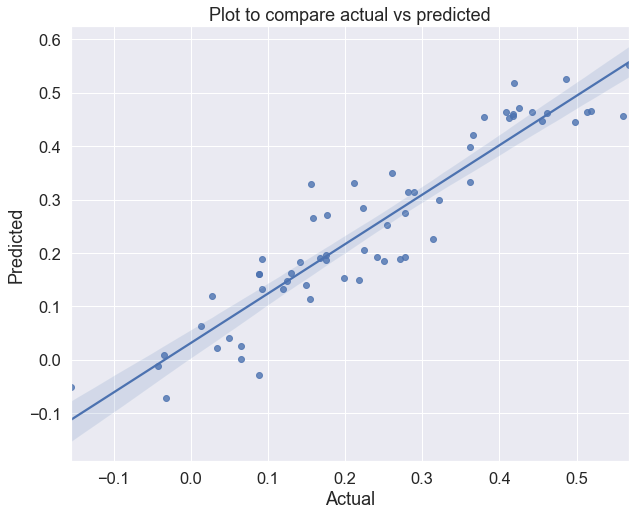

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

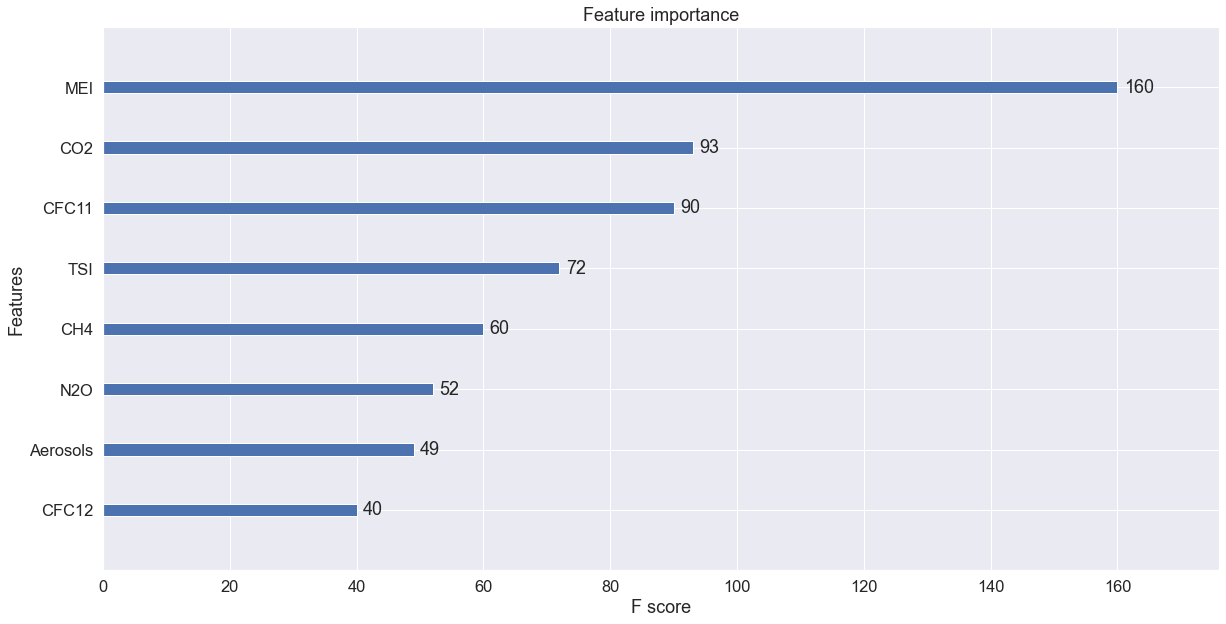

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax)
plt.show()

### Cross-Validation

In [41]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=2,scoring='r2')
cv

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.2s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s
[CV]  ................................................................
[CV] ................................................. , total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


array([-0.88466499, -0.43881061,  0.34011706, -0.48710007, -0.83388851])

In [42]:
cv.mean()

-0.46086942530986186

### Feature Selection

### Model Prediction

### Model Tuning

In [43]:
model = XGBRegressor(random_state=0, n_estimators=300, objective='reg:squarederror')

In [44]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [45]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, n_jobs=-1)

In [46]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=300,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [47]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=0,
             importance_type='gain', learning rate=0.05, learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=3, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.5, verbosity=1)

In [48]:
randm.best_score_

-0.2608121106919283

In [49]:
randm.best_params_

{'subsample': 0.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 8,
 'learning rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.7999999999999999}

### New Model

In [ ]:
xgbnew = XGBClassifier(random_state=0, n_estimators=500, objective='binary:logistic',max_depth= 7,
                      gamma= 10, min_child_weight= 1)

In [ ]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

In [ ]:
y_pred_new = xgbnew.predict(X_test)

In [ ]:
y_pred_new